# Job Rejection Letters Analysis![title](images/AppRejected.JPG)

# Packages and Libraries Imports

In [1]:
import sys
import os
import time
import re
import csv
import pandas as pd
import numpy as np

import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from collections import Counter
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble  import AdaBoostRegressor

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.3)



import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


[nltk_data] Downloading package punkt to /home/hvyd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/hvyd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Processing and Feature Exploratorion
### Import and Clean Data

In [2]:
df = pd.read_csv('data/my_rejections.csv')
df = df.dropna()
df.head()

,Date,Time,Day,Hour,Subject,Text
0,7/12/2018 12:31,12:31:08,Thurs,12.0,Your IBM Application,Ref: 110127BR - 2018 Data Scientist \n\nDear S...
1,6/12/2018 16:30,16:30:28,Tues,16.0,Thank you from Workday!,"<!doctype html><html xmlns:o=3D""urn:schemas-mi..."
2,5/17/2018 8:43,8:43:38,Thurs,8.0,An Update Regarding Your Visa Job Application,"\nDear Scott,\nThank you for giving us the opp..."
3,5/1/2018 15:21,15:21:05,Tues,15.0,Thank you for your interest in Zynga for Inter...,<html><head>\n<meta http-equiv=3DContent-Type ...
4,4/26/2018 14:49,14:49:02,Thurs,14.0,Your Application with Cambia Health Solutions,"Dear Scott,\n=C2=A0\nThank you for the interes..."


### WordCloud of DataFrame words for fun

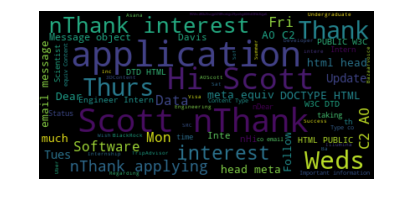

In [3]:
wordcloud = WordCloud(max_font_size=42).generate(str(df))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 0 to 85
Data columns (total 6 columns):
Date       61 non-null object
Time       61 non-null object
Day        61 non-null object
Hour       61 non-null float64
Subject    61 non-null object
Text       61 non-null object
dtypes: float64(1), object(5)
memory usage: 3.3+ KB


In [5]:
df.shape

(61, 6)

### Visualize number of rejections by Day

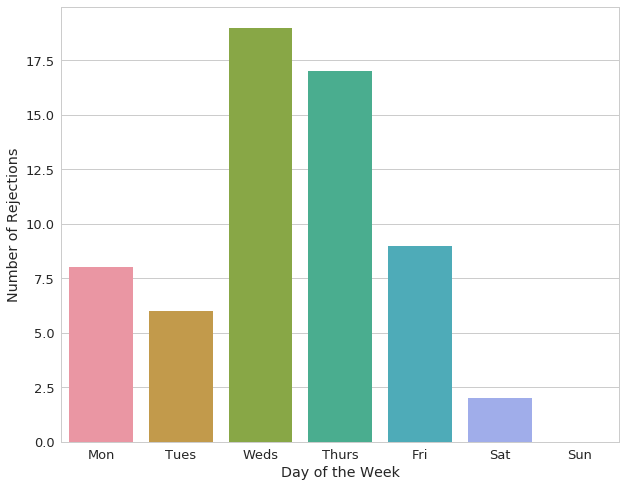

In [6]:
plt.figure(figsize=(10,8))
sns.countplot(df['Day'], order=['Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat', 'Sun']);
plt.xlabel('Day of the Week')
plt.ylabel('Number of Rejections')
plt.show()

### Lets see which company likes to send weekend and late night rejections

In [7]:
sat = df.loc[df['Day'] == 'Sat']
print("1:",sat.iloc[0]['Subject'], '---->', sat.iloc[0]['Day'],'@', sat.iloc[0]['Time'],'PST')
print("2:",sat.iloc[1]['Subject'], '---->', sat.iloc[1]['Day'], '@', sat.iloc[1]['Time'],'PST')

1: Important information about your application to LendUp ----> Sat @ 15:04:42 PST
2: Thank you for your interest in TripAdvisor ----> Sat @ 7:27:04 PST


### Visualize Number of Rejections by Hour of the Day

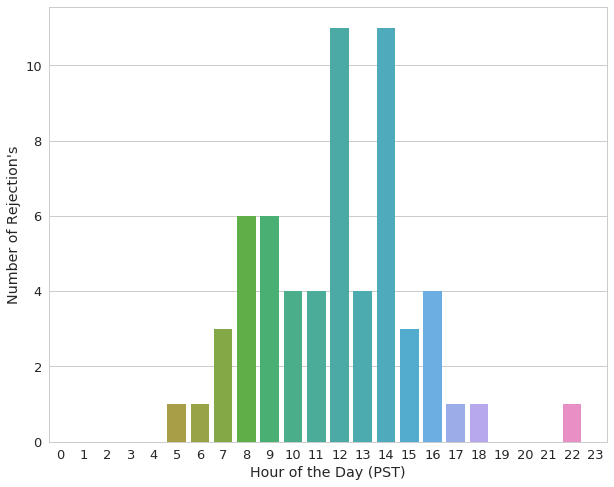

In [8]:
#Visualization
plt.figure(figsize=(10,8))
sns.countplot(df['Hour'], order=np.arange(0,24));
plt.xlabel('Hour of the Day (PST)')
plt.ylabel("Number of Rejection's")
plt.show()

#### Late Night Rejection Culprit

In [9]:
late = df.loc[df['Hour'] == 22]
print("1:",late.iloc[0]['Subject'], '---->', late.iloc[0]['Day'],'@', late.iloc[0]['Time'],'PST')

1: P&G ----> Thurs @ 22:08:37 PST


# NLP
### List of common words and counts

In [28]:
subject_str = df['Subject'].to_string()
words = nltk.word_tokenize(subject_str)
clean = [word for word in words if word not in stopwords.words('english')]

punctuation = re.compile(r'[-.?!,":;()|0-9]')
clean = [punctuation.sub("", word) for word in clean]
clean = [word.lower() for word in clean if len(word) > 0]

words = [item[0] for item in Counter(clean).most_common(10)]
counts = [item[1] for item in Counter(clean).most_common(10)]

words_counts = list(zip(words, counts))
words_counts

[('application', 34),
 ('your', 16),
 ('thank', 10),
 ('interest', 8),
 ('data', 7),
 ('intern', 7),
 ('software', 7),
 ('update', 6),
 ('thanks', 5),
 ('scott', 5)]

### Visualization of Comon words by Count

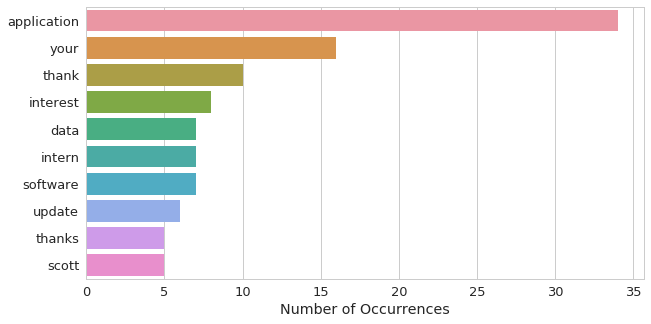

In [11]:
plt.figure(figsize=(10,5))
sns.barplot(counts, words);
plt.ylabel('');
plt.xlabel('Number of Occurrences')
plt.show()

### WordCloud of common words for fun

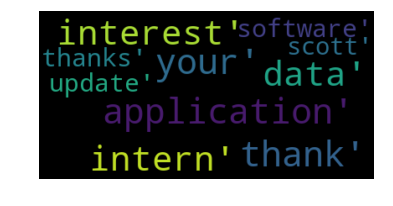

In [12]:
wordcloud = WordCloud(max_font_size=42).generate(str(words))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


# ML
### Random Forest

In [29]:
y_counts = [item[1] for item in Counter(clean).most_common((61))]
X = df[['Hour']].values
y = y_counts

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [31]:
forest = RandomForestRegressor(n_estimators=500, criterion='mse', random_state=42, n_jobs=-1)

In [32]:
forest.fit(X_train, y_train)

ValueError: could not convert string to float: 'data'

In [17]:
y_train_pred = forest.predict(X_train)

In [18]:
y_test_pred = forest.predict(X_test)

In [19]:
print("MSE train: {0:.4f}, test: {1:.4f}".\
      format(mean_squared_error(y_train, y_train_pred), 
             mean_squared_error(y_test, y_test_pred)))

MSE train: 5.5334, test: 61.6290


In [20]:
print("R2 train: {0:.4f}, test: {1:.4f}".\
     format(r2_score(y_train, y_train_pred),
           r2_score(y_test, y_test_pred)))

R2 train: 0.2836, test: -0.1608


### AdaBoost

In [21]:
ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                        n_estimators=500, random_state=42)

In [22]:
ada.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=500,
         random_state=42)

In [23]:
y_train_pred = ada.predict(X_train)

In [24]:
y_test_pred = ada.predict(X_test)

In [25]:
print("MSE train: {0:.4f}, test: {1:.4f}".\
      format(mean_squared_error(y_train, y_train_pred), 
             mean_squared_error(y_test, y_test_pred)))

MSE train: 5.9849, test: 61.3068


In [26]:
print("R2 train: {0:.4f}, test: {1:.4f}".\
     format(r2_score(y_train, y_train_pred),
           r2_score(y_test, y_test_pred)))

R2 train: 0.2251, test: -0.1547
